# Библиотеки

In [147]:
# Для работы с данными
import pandas as pd
import numpy as np
import glob
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from scipy.linalg import hankel
# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
# Процесс выполнения
from tqdm.notebook import tqdm,trange
# Tensorflow
import tensorflow
from tensorflow.keras import Input,Model
from tensorflow.keras.layers import Dense, concatenate, Dropout, LSTM

# Отдельные модули
import preprocessing
import micro_model_functions
import micro_help_functions
import macro_model_functions
# !!!!!!!!!!!!!!!!убрать
import importlib


# Загрузка данных

In [2]:
path_to_dataset = 'user_trans.csv'
df = pd.read_csv(path_to_dataset)

print('df shape: ', df.shape)
df.head()

df shape:  (12807982, 6)


,REGNUM,TRANS_DATE,mcc,PRC_AMT,date,group
0,158892,2020-01-30 09:17:33,5411,163.00,2020-01-30,food
1,15403,2020-01-31 17:40:59,5411,984.50,2020-01-31,food
2,2680437,2020-01-31 15:08:59,5411,542.09,2020-01-31,food
3,1136161,2020-01-30 09:19:13,5411,215.93,2020-01-30,food
4,3054580,2020-01-31 14:27:07,5411,239.00,2020-01-31,food


# Предобработка данных

## Переход к трем категориям ценностей

In [3]:
# если есть только MCC-коды, то сначала переходим к 14-ти категориям
df = preprocessing.cats_to_14(df=df, col='mcc', new_col='group')
df.head()

,REGNUM,TRANS_DATE,mcc,PRC_AMT,date,group
0,158892,2020-01-30 09:17:33,5411,163.00,2020-01-30,food
1,15403,2020-01-31 17:40:59,5411,984.50,2020-01-31,food
2,2680437,2020-01-31 15:08:59,5411,542.09,2020-01-31,food
3,1136161,2020-01-30 09:19:13,5411,215.93,2020-01-30,food
4,3054580,2020-01-31 14:27:07,5411,239.00,2020-01-31,food


In [4]:
# не будем учитывать категорию деньги
df = df[~df['group'].isin(['money'])]
# Составляем словарь вида "MCC-код":"категория"
cats_3_dict = {'food':'survival', 'outfit':'survival', 'dwelling':'survival', 'health':'survival',
     'remote':'socialization','travel':'socialization','nonfood':'socialization','telecom':'socialization','misc':'socialization',
     'beauty':'self_realization', 'kids':'self_realization','fun':'self_realization', 'charity':'self_realization'}

# Создаем новую колонку с тремя категориями
df['group_3'] = df['group'].apply(lambda x: cats_3_dict[x])
df['group_3'].value_counts()

survival            6952773
socialization       2910513
self_realization    1495481
Name: group_3, dtype: int64

## Составление датафрейма: факт совершения транзакций, общая сумма за день

In [5]:
bin_compressed = preprocessing.create_trans_data(df=df, col_clientid='REGNUM', col_date='date', 
                                   col_group='group_3', col_amount='PRC_AMT')
bin_compressed.head()

,bin_trans,money_trans
913,"[[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,...","[[0, 0, 669, 0, 0, 0, 489, 0, 0, 596, 0, 265, ..."
1490,"[[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 100, 2120, 2029, 910, 0..."
1879,"[[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 54, 187, 54, 0, 5100..."
2021,"[[0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,...","[[0, 160, 915, 0, 0, 0, 0, 0, 0, 100, 932, 490..."
2079,"[[1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,...","[[22, 393, 927, 0, 0, 1901, 0, 0, 0, 0, 0, 370..."


In [110]:
# Сохраним для того, чтобы получить реальные id клиентов и сумму позже
bin_compressed.to_pickle('real_id_bin_money.pkl')

## Добавление признаков из даты

К данным по транзакциям добавим информацию о дне неделе и месяце, которые были закодированы с помощью синуса и косинуса для обеспечения одинакового расстояния между всеми элементами. 

In [6]:
df.date.min(), df.date.max()

('2020-01-01', '2021-06-29')

In [7]:
feat_df = preprocessing.add_date_features(start_date=df.date.min(), end_date=df.date.max(),
                                          main_feat_trans=bin_compressed['bin_trans'])
feat_df

0       [[0.0, 0.0, 1.0, 0.9749279121818236, -0.222520...
1       [[0.0, 0.0, 0.0, 0.9749279121818236, -0.222520...
2       [[0.0, 1.0, 0.0, 0.9749279121818236, -0.222520...
3       [[0.0, 0.0, 1.0, 0.9749279121818236, -0.222520...
4       [[1.0, 0.0, 0.0, 0.9749279121818236, -0.222520...
                              ...                        
7280    [[0.0, 0.0, 0.0, 0.9749279121818236, -0.222520...
7281    [[0.0, 0.0, 0.0, 0.9749279121818236, -0.222520...
7282    [[0.0, 0.0, 0.0, 0.9749279121818236, -0.222520...
7283    [[0.0, 0.0, 0.0, 0.9749279121818236, -0.222520...
7284    [[0.0, 0.0, 0.0, 0.9749279121818236, -0.222520...
Length: 7285, dtype: object

В итоге, каждый день представляет собой вектор из семи признаков (факт совершения транзакции первой категории, второй, третьей, синус и косинус дня недели, синус и косинус месяца), что дает окончательную размерность признакового пространства для каждого пользователя, равную 546х7.

In [8]:
feat_df.iloc[0].shape

(546, 7)

## Выбор клиентов

При большом наличии клиентов появилась необходимость отобрать тех, кто более-менее регулярно совершает покупки

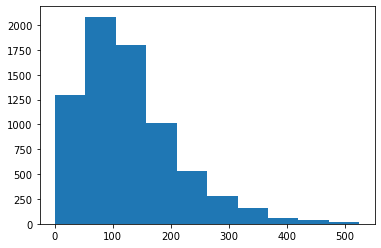

In [9]:
# Посмотрим на кол-во дней с совершенными транзакциями (из 546 возможных) по первой категории у каждого клиента
w = feat_df.apply(lambda x: x[x[:,0]==1].shape[0]).sort_values(ascending=False)
plt.hist(w);

In [11]:
# Оставим только пользователей с количеством дней с транзакциями не менее 100
nonzero_clients = w[w>100].index
feat_df_nonzero = feat_df.loc[nonzero_clients.sort_values()]
feat_df_nonzero.shape

(4054,)

## Меняем временной интервал

Так как одна из задач -- оценка динамики предсказуемости при наличии переходных финансовых процессов, то было необходимо оставить кризисный период конец марта — начало апреля 2020 года для тестовой выборки. 

Руководствуясь предположением, что поведение пользователей банковских карт слабо меняется в зависимости от года, был изменен порядок дней: промежуток 01.01.20 — 29.06.20 поменялся местами с полугодием 01.01.21 — 29.06.21, что дало итоговый искусственный интервал 01.01.2019 - 29.06.2020.


In [12]:
# заменим 01.21-06.21 на 01.20-06.20, т.е. поменяем их местами
feat_df_nonzero = feat_df_nonzero.apply(lambda x: np.concatenate((x[366:], # 01.01.21 - ... теперь это 2019 год
                                        x[181:366], # оставляем середину (теперь это 2019)
                                        x[:181])))
feat_df_nonzero

1       [[0.0, 0.0, 1.0, -0.433883739117558, -0.900968...
2       [[0.0, 0.0, 0.0, -0.433883739117558, -0.900968...
3       [[0.0, 1.0, 1.0, -0.433883739117558, -0.900968...
4       [[0.0, 0.0, 0.0, -0.433883739117558, -0.900968...
5       [[0.0, 0.0, 0.0, -0.433883739117558, -0.900968...
                              ...                        
7262    [[0.0, 1.0, 1.0, -0.433883739117558, -0.900968...
7264    [[0.0, 1.0, 1.0, -0.433883739117558, -0.900968...
7268    [[1.0, 1.0, 1.0, -0.433883739117558, -0.900968...
7271    [[0.0, 0.0, 0.0, -0.433883739117558, -0.900968...
7283    [[0.0, 0.0, 1.0, -0.433883739117558, -0.900968...
Length: 4054, dtype: object

In [ ]:
#feat_df_nonzero.to_pickle("4054_amnt_binclass_3c.pkl", protocol=4)

# Предсказания на микро-уровне (каждый клиент)

## Обучающая и тестовая выборки

Разделение данных на обучающую (с 1 января по 31 декабря 2019) и тестовую (25 недель с 1 января по 23 июня 2020) выборки

In [87]:
n_train=365
train_df = feat_df_nonzero.apply(lambda x: x[ : n_train])
test_df = feat_df_nonzero.apply(lambda x: x[n_train : ])

In [89]:
np.random.seed(42)

# Зададим порядок клиентов 
clients = feat_df_nonzero.index
random_clients = np.random.choice(clients,size=clients.shape[0],replace=False)
random_clients[:10]

array([1682, 1396, 2712, 3644, 1955, 1301, 6497, 4369, 2096, 1638],
      dtype=int64)

## Предсказания для базовой и инкрементальной моделей

In [90]:
client_dict = {}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Для каждого клиента отдельная модель
for client_id in tqdm(random_clients[:1], desc='clients'):
    b_cats_r = []
    i_cats_r = []
    
    # Получим данные для клиента 
    all_x,all_y,all_test_x,all_test_y = micro_help_functions.get_splits_by_client(client_id, train_df, test_df)
    
    # Для каждой категории отдельная модель
    for cat in range(3):
        
        # Обучаем базовую модель
        cl_model, cl_optimizer, train_losses, test_losses, cl_checkpoint, weights = micro_model_functions.train_model(all_x,all_y,
                                                                                       all_test_x,all_test_y, 
                                                                                       e_n=1000, lr=0.0005,cat=cat)
        
        # Сохраняем базовую модель, чтобы потом на ее основе сделать инкрементальную модель
        torch.save(cl_checkpoint, f'model_{cat}.pth')
        model_after = micro_model_functions.LSTM_cat_model(input_size=5, hidden_size=64, to_pred=7).to(device)
        checkpoint = torch.load(f'./model_{cat}.pth')
        model_after.load_state_dict(checkpoint['model'])
        
        # Разделим временной интервал тестовой выборки на недели
        days = pd.date_range('2020-01-01','2020-06-23')
        days = np.array(days).reshape(-1,7).astype('datetime64[D]')
        # Получим данные для клиента с указанной датой для дней, которые будут предсказываться
        q = micro_help_functions.get_df_full_y_new(feat_df.loc[client_id][337:], 
                                                   min_date='2019-12-04', max_date='2020-06-29')[::7]

        # Результаты базовой модели для тестовых недель
        b_r = micro_model_functions.base_model_data(q,model_after,days,cat=cat)
        b_cats_r.append(b_r)

        # Загружаем базовую модель
        the_checkpoint = torch.load(f'./model_{cat}.pth')
        imodel_after = micro_model_functions.LSTM_cat_model(input_size=5, hidden_size=64, to_pred=7).to(device)
        imodel_after.load_state_dict(the_checkpoint['model'])
        ioptimizer_after = torch.optim.Adam(params=filter(lambda p: p.requires_grad, imodel_after.parameters()),lr=0.0005)
        ioptimizer_after.load_state_dict(the_checkpoint['optimizer'])
        # Меняем шаг обучения у оптимизатора
        for param_group in ioptimizer_after.param_groups:
            param_group['lr'] = 0.05
        
        # Результаты инкрементальной модели для тестовых недель
        i_r = micro_model_functions.incr_model_data(q, imodel_after,days,ioptimizer_after, weights,with_weights=True,cat=cat)
        i_cats_r.append(i_r)
    
    # Сохраняем предсказания и реальные значения для двух моделей
    client_dict[client_id] = [b_cats_r,i_cats_r]

clients:   0%|          | 0/1 [00:00<?, ?it/s]

epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

In [91]:
d = pd.DataFrame.from_dict(client_dict).T
#d.to_pickle('3300-4122_real_yt_yp.pkl')
d

,0,1
1682,"[[[[0. 0. 0. 1. 0. 1. 0.], [1 1 1 1 1 1 1]], [...","[[[[0. 0. 0. 1. 0. 1. 0.], [[1 1 1 1 1 1 1]]],..."


## Сравнение базовой модели с инкрементальной 

In [95]:
path_to_2models_data_folder = 'sim_clients/'

# Загрузим данные
df_2models = pd.concat(map(pd.read_pickle, glob.glob(path_to_2models_data_folder+'*.pkl')))
df_2models = df_2models[~df_2models.index.duplicated(keep='first')]
df_2models.columns = [['base','inc']]

df_2models.head()

,base,inc
1682,"[[[[0. 0. 1. 0. 0. 0. 0.], [1 1 1 1 1 1 1]], [...","[[[[0. 0. 1. 0. 0. 0. 0.], [[1 1 1 1 1 1 1]]],..."
1396,"[[[[0. 0. 1. 1. 0. 1. 0.], [1 1 1 1 1 1 1]], [...","[[[[0. 0. 1. 1. 0. 1. 0.], [[1 1 1 1 1 1 1]]],..."
2712,"[[[[0. 0. 1. 0. 1. 0. 0.], [1 1 1 1 1 1 1]], [...","[[[[0. 0. 1. 0. 1. 0. 0.], [[1 1 1 1 1 1 1]]],..."
3644,"[[[[0. 0. 1. 0. 0. 0. 1.], [0 0 0 0 0 0 0]], [...","[[[[0. 0. 1. 0. 0. 0. 1.], [[0 0 0 0 0 0 0]]],..."
1955,"[[[[0. 1. 0. 1. 1. 0. 1.], [1 1 1 1 1 1 1]], [...","[[[[0. 1. 0. 1. 1. 0. 1.], [[1 1 1 1 1 1 1]]],..."


In [101]:
importlib.reload(micro_help_functions)

<module 'micro_help_functions' from 'C:\\Users\\user\\Documents\\mk\\micro_help_functions.py'>

In [102]:
# Получим значения для каждой модели и "среднее" значение метрики
inc_with_metric, inc_with_metric_3in1, base_with_metric, \
base_with_metric_3in1 = micro_help_functions.get_base_inc_arrays(df_2models, micro_help_functions.F1metr)

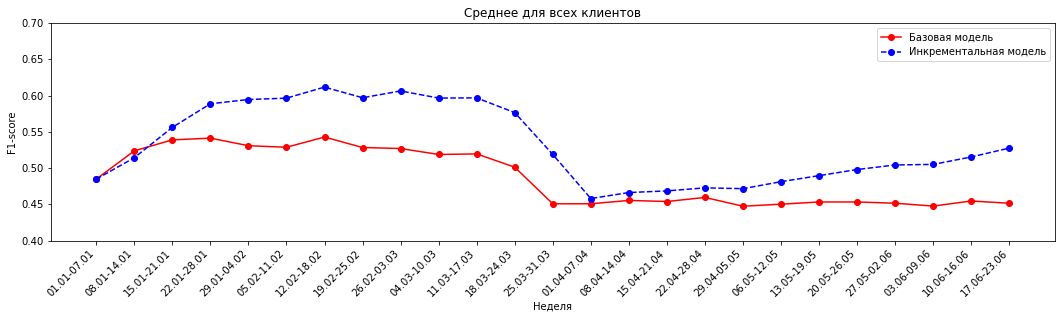

In [108]:
# Посмотрим на результаты двух моделей на тестовых неделях
plt.rcParams['figure.figsize'] = 18, 4

days = pd.date_range('2020-01-01','2020-06-23')
days = np.array(days).reshape(-1,7).astype('datetime64[D]')
a0 = pd.Series(days[:,0]).dt.strftime('%d.%m')
a1 = pd.Series(days[:,-1]).dt.strftime('%d.%m')

plt.plot(a0+'-'+a1, np.mean(base_with_metric_3in1,0),
         'ro-',label='Базовая модель')
plt.plot(a0+'-'+a1, np.mean(inc_with_metric_3in1,0),
         'bo--',label='Инкрементальная модель')

plt.ylim(0.4,0.7)
plt.xticks(rotation=45, ha='right')

plt.legend()
plt.xlabel('Неделя')
plt.ylabel('F1-score')
plt.title('Среднее для всех клиентов');

# Предсказания на мезо- (группы клиентов) и макро- (все клиенты) уровнях 

## Разделение клиентов по группам предсказуемости

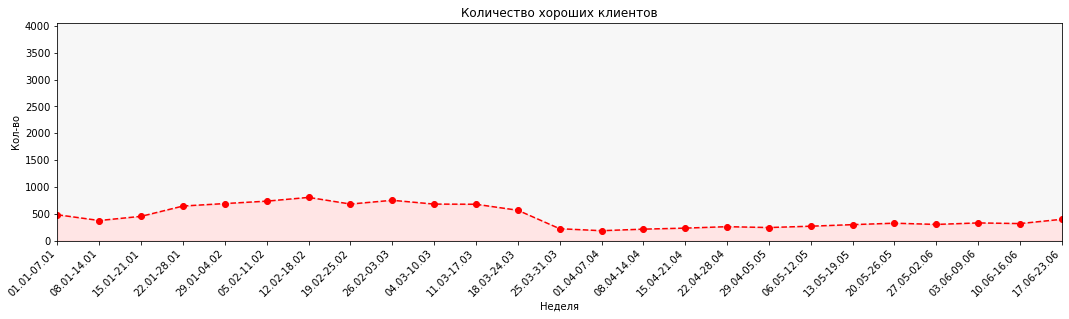

In [107]:
# Посчитаем кол-во хорошо-предсказуемых клиентов для каждой тестовой недели

threshold = 0.75 # порог метрики для определения хорошо и плохо предсказуемых 

# если метрика на опр. неделю выше порога -- ставим 1.
bool_clients = np.array([[int(x_week>threshold) for x_week in user] for user in inc_with_metric_3in1])


plt.plot(a0+'-'+a1, bool_clients.sum(0),'ro--')
plt.fill_between(a0+'-'+a1,bool_clients.sum(0), 0, color='red', alpha=0.1)
plt.fill_between(a0+'-'+a1, 4054, bool_clients.sum(0), color='gray', alpha=0.06)

plt.ylim(0,4054)
plt.margins(x=0)

plt.xticks(rotation=45, ha='right')
plt.title('Количество хороших клиентов')
plt.ylabel('Кол-во')
plt.xlabel('Неделя');

In [119]:
# Перейдем к реальным id клиентов

week_most_gclients = bool_clients.sum(0).argmax()
good_clients_idx = np.where(bool_clients[:,week_most_gclients]==1)
# Т.к. брали массивы из датасета, то индексы оттуда пропали; возвращаем соответствие!
good_clients_id_upto8k = pd.Series(df_2models.index).iloc[good_clients_idx].values

# Берем данные с реальными id
df_real_id = pd.read_pickle('real_id_bin_money.pkl')
good_clients_id = pd.Series(df_real_id.index).iloc[good_clients_id_upto8k].values
print('Самое большое кол-во хороших клиентов: ', good_clients_id.shape[0])

Самое большое кол-во хороших клиентов:  804


In [122]:
# Суммы хорошо-предсказуемых клиентов
gclients_amount = df_real_id.loc[good_clients_id]['money_trans']
# меняем полугодия местами, как и в начале
gclients_amount = gclients_amount.apply(lambda x: np.concatenate([x[:,366:], x[:,181:366], x[:,:181]],1))

# Суммы плохо-предсказуемых клиентов
# их реальные id
bad_clients_idx = np.where(bool_clients[:,week_most_gclients]==0)
bad_clients_id_upto8k = pd.Series(w.index).iloc[bad_clients_idx].values
bad_clients_id = pd.Series(df_real_id.index).iloc[bad_clients_id_upto8k].values
# суммы
bclients_amount = df_real_id.loc[bad_clients_id]['money_trans']
bclients_amount = bclients_amount.apply(lambda x: np.concatenate([x[:,366:], x[:,181:366], x[:,:181]],1))

# Суммы всех клиентов
all_clients_amount = df_real_id.loc[pd.Series(df_real_id.index).iloc[w.index].values]['money_trans']
all_clients_amount = all_clients_amount.apply(lambda x: np.concatenate([x[:,366:], x[:,181:366], x[:,:181]],1))

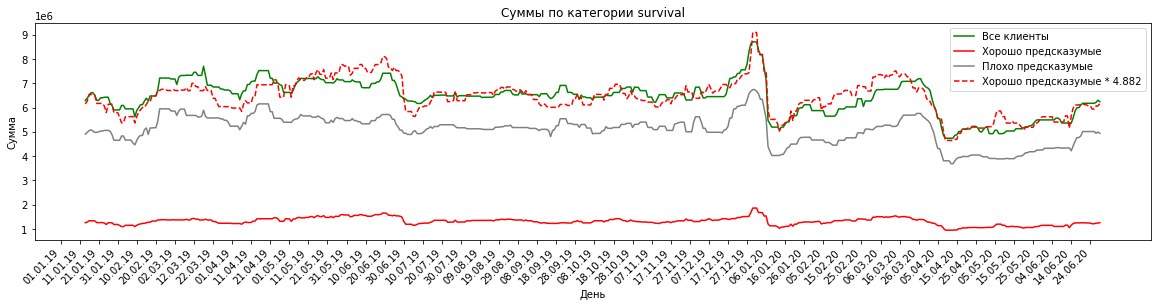

In [123]:
# Посмотрим на суммы разных групп клиентов

dates = pd.Series(pd.date_range('2019-01-01','2020-06-29')).dt.strftime('%d.%m.%y')

ws = 14

# Скользящая медиана, чтобы избавиться от провалов в конце кварталов и аномально богатых
all_rw = pd.Series(np.array(all_clients_amount.to_list()).sum(0)[2,:]).rolling(window=ws).median()
good_rw = pd.Series(np.array(gclients_amount.to_list()).sum(0)[2,:]).rolling(window=ws).median()
bad_rw = pd.Series(np.array(bclients_amount.to_list()).sum(0)[2,:]).rolling(window=ws).median()

fig = plt.figure(figsize=(20, 4))

plt.plot(dates,all_rw, 'g-', label='Все клиенты')
plt.plot(dates,good_rw, 'r-', label='Хорошо предсказумые')
plt.plot(dates,bad_rw, '-', c='gray',label='Плохо предсказумые')
c = all_rw.mean()/good_rw.mean()
plt.plot(dates,good_rw*c, 'r--',label=f'Хорошо предсказумые * {c:.3f}')

plt.title('Суммы по категории survival')
plt.xlabel('День')
plt.ylabel('Сумма')

plt.xticks(dates[::10], rotation=45, ha='right')
plt.legend();

In [125]:
all_rw.to_csv('all_rw_n_sur.csv', index=False)
good_rw.to_csv('good_rw_n.csv', index=False)
bad_rw.to_csv('bad_rw_n.csv', index=False)

## Предсказания

Инкрементально предсказываются 15 дней от 29 марта до 29 июня 2020 года с 0-го по 14-й на основе предыдущих 28 дней, сдвигается начало на один день, предсказываются 15 дней с 1-го по 15-й на основе предыдущих 28 дней и так далее, пока не будет достигнут конец .

In [144]:
# Читаем данные по группам клиентов
all_rw = pd.read_csv('all_rw_n_sur.csv')
good_rw = pd.read_csv('good_rw_n.csv')
bad_rw = pd.read_csv('bad_rw_n.csv')

# Задаем гиперпараметры модели
n_epochs_each_model = 65
n_batch_each_model = 27 #10 from 03/02 
lr_each_model = 0.00001
n_neurons_each_model = 80

# Параметры для 
dim=28 #размерность вложения
mem=5 #глубина памяти для LSTM
split=93 #Разбиение ряда для обучения\прогноза (от конца)
fwd = 15 # На сколько дней предсказываем на тестовой
imp_num_max = split-fwd-1 # Кол-во предсказаний
arr = hankel(np.arange(150))[:imp_num_max,:fwd] # Матрица для вычисления медианы предсказаний

days = pd.date_range('2019-01-01','2020-06-29')
days = pd.Series(days).dt.strftime('%d.%m.%Y')

### Хорошо предсказуемые

In [134]:
# Готовим данные

# ОТДЕЛЬНО нормализуем трейн и тест
scaler = MinMaxScaler(clip=False, feature_range=(-1, 1))
dat_train = scaler.fit_transform(good_rw[13:-split])
dat_test = scaler.transform(good_rw[-split:])
dat = np.concatenate((dat_train,dat_test))
# Составляем сдвиги временного ряда
ser=dat_train.reshape(-1)[:]
X, y = macro_model_functions.MakeSet(ser, dim, mem)

X.shape, y.shape

((406, 5, 28), (406, 1))

In [135]:
# Если до этого прогнозировали, то выкидываем из памяти лишнее
try:
    del model_good
except:
    pass

model_good = macro_model_functions.fit_lstm(X[:-1], y[:], n_epochs_each_model, n_batch_each_model, 
                                            n_neurons_each_model, additional=[],learning_rate=lr_each_model) #only historical

Epoch 1/65
12/12 [==============================] - 1s 43ms/step - loss: 0.1435 - mape: 125.8376 - val_loss: 0.2198 - val_mape: 112.9163
Epoch 2/65
12/12 [==============================] - 0s 40ms/step - loss: 0.1423 - mape: 124.2942 - val_loss: 0.2161 - val_mape: 111.9643
Epoch 3/65
12/12 [==============================] - 0s 40ms/step - loss: 0.1374 - mape: 122.2982 - val_loss: 0.2126 - val_mape: 111.0330
Epoch 4/65
12/12 [==============================] - 0s 40ms/step - loss: 0.1342 - mape: 117.4651 - val_loss: 0.2093 - val_mape: 110.1075
Epoch 5/65
12/12 [==============================] - 0s 40ms/step - loss: 0.1308 - mape: 117.5023 - val_loss: 0.2062 - val_mape: 109.2099
Epoch 6/65
12/12 [==============================] - 0s 40ms/step - loss: 0.1304 - mape: 115.3081 - val_loss: 0.2032 - val_mape: 108.3198
Epoch 7/65
12/12 [==============================] - 0s 40ms/step - loss: 0.1238 - mape: 111.1545 - val_loss: 0.2005 - val_mape: 107.4340
Epoch 8/65
12/12 [=======================

In [162]:
# Делаем новую модель, чтобы предсказывать с батчем == 1.
# Тк у нас stateful LSTM, то размер батча фиксирован, 
# поэтому воспользуемся таким способом, чтобы предсказывать с др. батчем

in1 = Input(batch_shape = (1,X.shape[1], X.shape[2]))
out = LSTM(n_neurons_each_model, batch_input_shape=(1, X.shape[1], X.shape[2]), 
                stateful=True, return_sequences=False, activation='relu')(in1)
out = Dense(32, activation='relu')(out)
out = Dropout(0.1)(out)
x = Dense(y.shape[1], activation='linear')(out)
    
model_for_pred = Model(inputs=[in1], outputs=x)
fitdat=[X]
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=lr_each_model)
model_for_pred.compile(loss='mean_squared_error',metrics=['mape'], optimizer=optimizer,  run_eagerly=True)
model_for_pred.set_weights(model_good.get_weights())

In [148]:
# Смотрим, как модель подстроилась под обучающую выборку

y_pred = []
for i in trange(len(X)):
    y_pred.append(model_for_pred.predict([X[i:i+1]], verbose=0))
# Трансформируем из нормализованных  
y_pred_tr = scaler.inverse_transform(np.array(y_pred).reshape(-1,1)).reshape(-1)
y_true = good_rw[13+mem+dim:-split].values.reshape(-1)

# Прогнозируем на <fwd> шагов
fwd_mapes = []
full_fwd_pred_tr = []
full_fwd_true = []
for imp_num in trange(0,imp_num_max):
    # Предсказания
    fwd_pred = macro_model_functions.make_forecast(model_for_pred, dat.reshape(-1), [], dim, mem, split, imp_num, fwd)
    # Трансформируем значения из нормализованных
    fwd_pred_tr = scaler.inverse_transform(fwd_pred.reshape(-1,1)).reshape(-1)
    # Реальные данные за тот же промежуток
    fwd_true = good_rw[-split+imp_num:-split+imp_num+fwd].values.reshape(-1)
    
    full_fwd_pred_tr.append(fwd_pred_tr)
    full_fwd_true.append(fwd_true)
    # Считаем MAPE
    fwd_mapes.append(mean_absolute_percentage_error(fwd_true, fwd_pred_tr))

# Медиана предсказаний 
# (на первый день 1 значение, на второй -- 2, в середине -- 15)
median_preds = []
for i in range(split-2):
    a0,a1 = np.where(np.array(arr)==i)
    median_preds.append(np.median(np.array(full_fwd_pred_tr)[a0,a1]))

  0%|          | 0/406 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

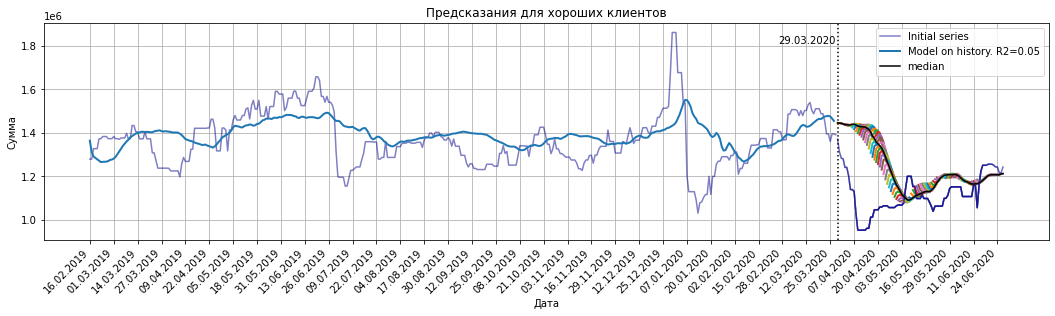

train MAPE: 6.562%
test MAPE median: 7.675%
test MAPE HP: 71.429%


In [153]:
# График

plt.rcParams['figure.figsize'] = 18, 4
# Реальные данные
yt = good_rw[13+mem+dim:-split].values.reshape(-1)

ticks=days.iloc[13+mem+dim:]
xt=np.arange(0, len(ticks), 13)

plt.plot(yt, c='darkblue', alpha=.5, label='Initial series')
plt.plot(y_pred_tr, lw=2, label=f'Model on history. R2={r2_score(y_true[1:], y_pred_tr):.2f}')

# Все предсказания по 15 дней
for imp_num in range(0,imp_num_max):
    t=np.arange(len(yt)+imp_num, len(yt)+imp_num+fwd)
    plt.plot(t, full_fwd_true[imp_num], c='darkblue', alpha=.1, label=None)
    plt.plot(t, full_fwd_pred_tr[imp_num], lw=2)

plt.plot(np.arange(len(yt), len(yt)+split-2), median_preds, label='median', c='black')
plt.plot(np.arange(len(yt), len(yt)+split-2), good_rw[-split:-2].values.reshape(-1),c='darkblue', alpha=.5)
    
plt.axvline(len(yt), ls=':', c='k')
plt.text((len(yt))*0.92, plt.gca().get_ylim()[1]*0.95, 
         f'{days.iloc[-split]}', rotation=0)
plt.xticks(xt, ticks.iloc[xt], rotation=45, ha='right')

plt.title('Предсказания для хороших клиентов')
plt.xlabel('Дата')
plt.ylabel('Сумма')

plt.legend()
plt.grid()
plt.show()

print(f'train MAPE: {mean_absolute_percentage_error( y_true[1:],y_pred_tr) * 100 :.3f}%')
print(f'test MAPE median: {np.median(np.array(fwd_mapes)) *100 :.3f}%')
print(f'test MAPE HP: {(np.where(np.array(fwd_mapes)<=0.15)[0].shape[0] / np.array(fwd_mapes).shape[0]) * 100 :.3f}%')

HP(Hit Probability): процент ошибок меньше заданного интервала

### Все клиенты

In [164]:
# Готовим данные
scaler_all = MinMaxScaler(clip=False, feature_range=(-1, 1))
dat_train_all = scaler_all.fit_transform(all_rw[13:-split])
dat_test_all = scaler_all.transform(all_rw[-split:])
dat_all = np.concatenate((dat_train_all,dat_test_all))

ser_all=dat_train_all.reshape(-1)[:]
X_all, y_all = macro_model_functions.MakeSet(ser_all, dim, mem)

# Обучаем модель
try:
    del model_all
except:
    pass

model_all=macro_model_functions.fit_lstm(X_all[:-1], y_all[:], n_epochs_each_model, n_batch_each_model, n_neurons_each_model, additional=[],
                  learning_rate=lr_each_model) #only historical

Epoch 1/65
12/12 [==============================] - 1s 49ms/step - loss: 0.0744 - mape: 132.2833 - val_loss: 0.3856 - val_mape: 128.2462
Epoch 2/65
12/12 [==============================] - 1s 45ms/step - loss: 0.0743 - mape: 134.7925 - val_loss: 0.3807 - val_mape: 126.3765
Epoch 3/65
12/12 [==============================] - 1s 44ms/step - loss: 0.0727 - mape: 135.0622 - val_loss: 0.3760 - val_mape: 124.5546
Epoch 4/65
12/12 [==============================] - 1s 45ms/step - loss: 0.0721 - mape: 134.7154 - val_loss: 0.3715 - val_mape: 122.7849
Epoch 5/65
12/12 [==============================] - 1s 44ms/step - loss: 0.0708 - mape: 136.7706 - val_loss: 0.3672 - val_mape: 121.0585
Epoch 6/65
12/12 [==============================] - 1s 44ms/step - loss: 0.0710 - mape: 126.7221 - val_loss: 0.3630 - val_mape: 119.4022
Epoch 7/65
12/12 [==============================] - 1s 43ms/step - loss: 0.0694 - mape: 127.0522 - val_loss: 0.3591 - val_mape: 117.8957
Epoch 8/65
12/12 [=======================

In [165]:
# Модель для предсказаний
in1 = Input(batch_shape = (1,X.shape[1], X.shape[2]))
out = LSTM(n_neurons_each_model, batch_input_shape=(1, X.shape[1], X.shape[2]), 
                stateful=True, return_sequences=False, activation='relu')(in1)
out = Dense(32, activation='relu')(out)
out = Dropout(0.1)(out)
x = Dense(y.shape[1], activation='linear')(out)
    
model_for_pred_all = Model(inputs=[in1], outputs=x)
fitdat=[X]
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=lr_each_model)
model_for_pred_all.compile(loss='mean_squared_error',metrics=['mape'], optimizer=optimizer,  run_eagerly=True)
model_for_pred_all.set_weights(model_all.get_weights())

# На обучающей
y_pred_all = []
for i in trange(len(X_all)):
    y_pred_all.append(model_for_pred_all.predict([X_all[i:i+1]], verbose=0))
y_pred_tr_all = scaler_all.inverse_transform(np.array(y_pred_all).reshape(-1,1)).reshape(-1)
y_true_all = all_rw[13+mem+dim:-split].values.reshape(-1)

# Прогнозируем на <fwd> шагов
fwd_mapes_all = []
full_fwd_pred_tr_all = []
full_fwd_true_all = []
for imp_num in trange(0,split-fwd-1):
    fwd_pred = macro_model_functions.make_forecast(model_for_pred_all, dat_all.reshape(-1), [], dim, mem, split, imp_num, fwd)
    fwd_pred_tr = scaler_all.inverse_transform(fwd_pred.reshape(-1,1)).reshape(-1)
    fwd_true = all_rw[-split+imp_num:-split+imp_num+fwd].values.reshape(-1)
    
    full_fwd_pred_tr_all.append(fwd_pred_tr)
    full_fwd_true_all.append(fwd_true)
    fwd_mapes_all.append(mean_absolute_percentage_error(fwd_true, fwd_pred_tr))
    
# Медианы предсказаний
median_preds_all = []
for i in range(split-2):
    a0,a1 = np.where(np.array(arr)==i)
    median_preds_all.append(np.median(np.array(full_fwd_pred_tr_all)[a0,a1]))


  0%|          | 0/406 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

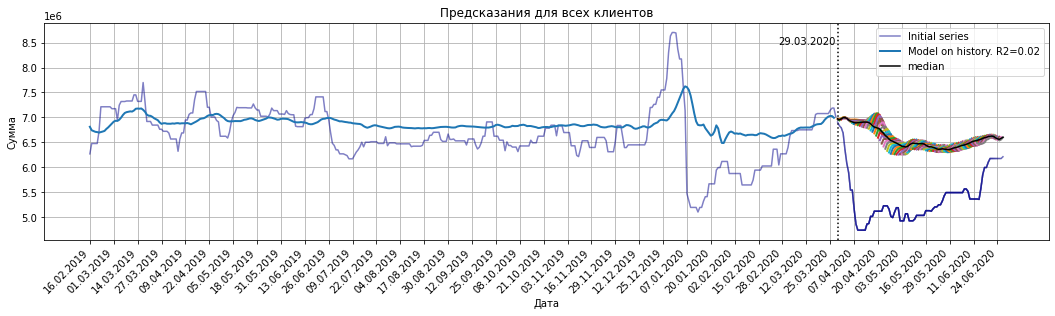

train MAPE: 6.101%
test MAPE median: 27.302%
test MAPE HP: 7.792%


In [166]:
# График
yt_all = all_rw[13+mem+dim:-split].values.reshape(-1)

ticks=days[13+mem+dim:]

xt=np.arange(0, len(ticks), 13)

plt.plot(yt_all, c='darkblue', alpha=.5, label='Initial series')
plt.plot(y_pred_tr_all, lw=2, label=f'Model on history. R2={r2_score(y_true_all[1:], y_pred_tr_all):.2f}')

for imp_num in range(0,split-fwd-1):

    t=np.arange(len(yt_all)+imp_num, len(yt_all)+imp_num+fwd)
    plt.plot(t, full_fwd_true_all[imp_num], c='darkblue', alpha=.1, label=None)
    plt.plot(t, full_fwd_pred_tr_all[imp_num], lw=2)
    

plt.axvline(len(yt_all), ls=':', c='k')
plt.text((len(yt_all))*0.92, plt.gca().get_ylim()[1]*0.95, 
         f'{days.iloc[-split]}', rotation=0)
plt.xticks(xt, ticks.iloc[xt], rotation=45, ha='right')

plt.plot(np.arange(len(yt_all), len(yt_all)+split-2), median_preds_all, label='median', c='black')
plt.plot(np.arange(len(yt_all), len(yt_all)+split-2), all_rw[-split:-2].values.reshape(-1),c='darkblue', alpha=.5)

plt.title('Предсказания для всех клиентов')
plt.xlabel('Дата')
plt.ylabel('Сумма')

plt.legend()
plt.grid()
plt.show()

print(f'train MAPE: {mean_absolute_percentage_error( y_true_all[1:],y_pred_tr_all) * 100 :.3f}%')
print(f'test MAPE median: {np.median(np.array(fwd_mapes_all)) * 100 :.3f}%')
print(f'test MAPE HP: {(np.where(np.array(fwd_mapes_all)<=0.15)[0].shape[0] / np.array(fwd_mapes_all).shape[0]) * 100 :.3f}%')

### Плохо предсказуемые

In [167]:
# Готовим данные
scaler_bad = MinMaxScaler(clip=False,feature_range=(-1, 1))
dat_train_bad = scaler_bad.fit_transform(bad_rw[13:-split])
dat_test_bad = scaler_bad.transform(bad_rw[-split:])
dat_bad = np.concatenate((dat_train_bad,dat_test_bad))

ser_bad=dat_train_bad.reshape(-1)[:]
X_bad, y_bad = macro_model_functions.MakeSet(ser_bad, dim, mem)

# Обучаем модель
try:
    del model_bad
except:
    pass
model_bad=macro_model_functions.fit_lstm(X_bad[:-1], y_bad[:], n_epochs_each_model, n_batch_each_model, n_neurons_each_model, additional=[],
                  learning_rate=lr_each_model) #only historical

Epoch 1/65
12/12 [==============================] - 1s 52ms/step - loss: 0.0690 - mape: 130.8779 - val_loss: 0.3692 - val_mape: 126.5803
Epoch 2/65
12/12 [==============================] - 1s 48ms/step - loss: 0.0687 - mape: 129.4890 - val_loss: 0.3684 - val_mape: 126.0877
Epoch 3/65
12/12 [==============================] - 1s 49ms/step - loss: 0.0679 - mape: 129.5072 - val_loss: 0.3676 - val_mape: 125.6135
Epoch 4/65
12/12 [==============================] - 1s 47ms/step - loss: 0.0672 - mape: 128.4276 - val_loss: 0.3667 - val_mape: 125.1257
Epoch 5/65
12/12 [==============================] - 1s 48ms/step - loss: 0.0656 - mape: 138.4811 - val_loss: 0.3659 - val_mape: 124.6433
Epoch 6/65
12/12 [==============================] - 1s 46ms/step - loss: 0.0660 - mape: 135.1974 - val_loss: 0.3650 - val_mape: 124.1328
Epoch 7/65
12/12 [==============================] - 1s 50ms/step - loss: 0.0659 - mape: 126.7073 - val_loss: 0.3642 - val_mape: 123.6624
Epoch 8/65
12/12 [=======================

In [170]:
# Модель для предсказаний
in1 = Input(batch_shape = (1,X.shape[1], X.shape[2]))
out = LSTM(n_neurons_each_model, batch_input_shape=(1, X.shape[1], X.shape[2]), 
                stateful=True, return_sequences=False, activation='relu')(in1)
out = Dense(32, activation='relu')(out)
out = Dropout(0.1)(out)
x = Dense(y.shape[1], activation='linear')(out)
    
model_for_pred_bad = Model(inputs=[in1], outputs=x)
fitdat=[X]
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=lr_each_model)
model_for_pred_bad.compile(loss='mean_squared_error',metrics=['mape'], optimizer=optimizer,  run_eagerly=True)
model_for_pred_bad.set_weights(model_bad.get_weights())

# На обучающей
y_pred_bad = []
for i in trange(len(X_bad)):
    y_pred_bad.append(model_for_pred_bad.predict([X_bad[i:i+1]], verbose=0))
y_pred_tr_bad = scaler_bad.inverse_transform(np.array(y_pred_bad).reshape(-1,1)).reshape(-1)
y_true_bad = bad_rw[13+mem+dim:-split].values.reshape(-1)

# Прогнозируем на <fwd> шагов
fwd_mapes_bad = []
full_fwd_pred_tr_bad = []
full_fwd_true_bad = []
for imp_num in trange(0,split-fwd-1):
    fwd_pred = macro_model_functions.make_forecast(model_for_pred_bad, dat_bad.reshape(-1), [], dim, mem, split, imp_num, fwd)
    fwd_pred_tr = scaler_bad.inverse_transform(fwd_pred.reshape(-1,1)).reshape(-1)
    fwd_true = bad_rw[-split+imp_num:-split+imp_num+fwd].values.reshape(-1)
    
    full_fwd_pred_tr_bad.append(fwd_pred_tr)
    full_fwd_true_bad.append(fwd_true)
    fwd_mapes_bad.append(mean_absolute_percentage_error(fwd_true, fwd_pred_tr))

# Медианы предсказаний
median_preds_bad = []
for i in range(split-2):
    a0,a1 = np.where(np.array(arr)==i)
    median_preds_bad.append(np.median(np.array(full_fwd_pred_tr_bad)[a0,a1]))

  0%|          | 0/406 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

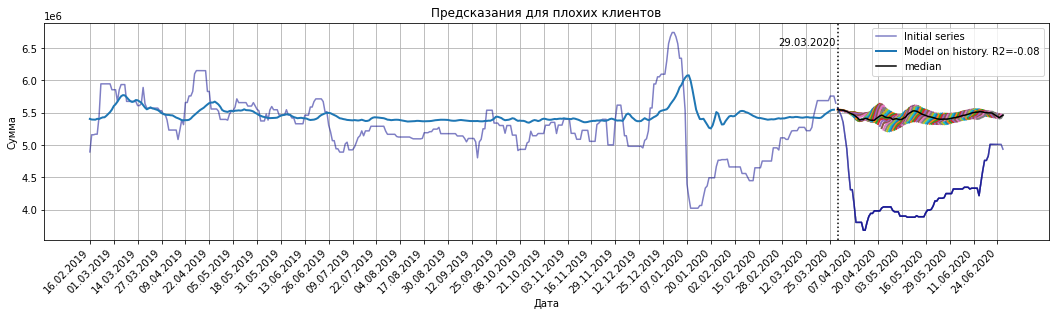

train MAPE: 6.359%
test MAPE median: 35.339%
test MAPE HP: 1.299%


In [171]:
# График
yt_bad = bad_rw[13+mem+dim:-split].values.reshape(-1)

ticks=days[13+mem+dim:]
xt=np.arange(0, len(ticks), 13)

plt.plot(yt_bad, c='darkblue', alpha=.5, label='Initial series')
plt.plot(y_pred_tr_bad, lw=2, label=f'Model on history. R2={r2_score(y_true_bad[1:], y_pred_tr_bad):.2f}')

for imp_num in range(0,split-fwd-1):
    t=np.arange(len(yt_bad)+imp_num, len(yt_bad)+imp_num+fwd)
    plt.plot(t, full_fwd_true_bad[imp_num], c='darkblue', alpha=.1, label=None)
    plt.plot(t, full_fwd_pred_tr_bad[imp_num], lw=2)

plt.plot(np.arange(len(yt_bad), len(yt_bad)+split-2), median_preds_bad, label='median', c='black')
plt.plot(np.arange(len(yt_bad), len(yt_bad)+split-2), bad_rw[-split:-2].values.reshape(-1),c='darkblue', alpha=.5)

plt.axvline(len(yt_bad), ls=':', c='k')
plt.text((len(yt_bad))*0.92, plt.gca().get_ylim()[1]*0.95, 
         f'{days.iloc[-split]}', rotation=0)
plt.xticks(xt, ticks.iloc[xt], rotation=45, ha='right')

plt.title('Предсказания для плохих клиентов')
plt.xlabel('Дата')
plt.ylabel('Сумма')

plt.legend()
plt.grid()
plt.show()

print(f'train MAPE: {mean_absolute_percentage_error(y_true_bad[1:], y_pred_tr_bad) * 100 :.3f}%')
print(f'test MAPE median: {np.median(np.array(fwd_mapes_bad)) * 100 :.3f}%')
print(f'test MAPE HP: {(np.where(np.array(fwd_mapes_bad)<=0.15)[0].shape[0] / np.array(fwd_mapes_bad).shape[0]) * 100 :.3f}%')

## Предсказания для хороших/плохих/всех сравниваем с реальными для всех клиентов

In [172]:
# Считаем MAPE для предсказаний хороших клиентов, умноженных на коэфф.
coeff = np.median(all_rw[13+mem+dim:-split].values.reshape(-1))/np.median(good_rw[13+mem+dim:-split].values.reshape(-1))
mape_good_pred_vs_all = []

for fwd_true, fwd_pred_tr in zip(full_fwd_true_all, full_fwd_pred_tr):
    mape_good_pred_vs_all.append(mean_absolute_percentage_error(fwd_true, fwd_pred_tr*coeff))
    
# Считаем MAPE для предсказаний плохих клиентов, умноженных на коэфф.
coeff_bad = np.median(all_rw[13+mem+dim:-split].values.reshape(-1))/np.median(bad_rw[13+mem+dim:-split].values.reshape(-1))    
mape_bad_pred_vs_all = []

for fwd_true, fwd_pred_tr in zip(full_fwd_true_all, full_fwd_pred_tr_bad):
    mape_bad_pred_vs_all.append(mean_absolute_percentage_error(fwd_true, fwd_pred_tr*coeff_bad))

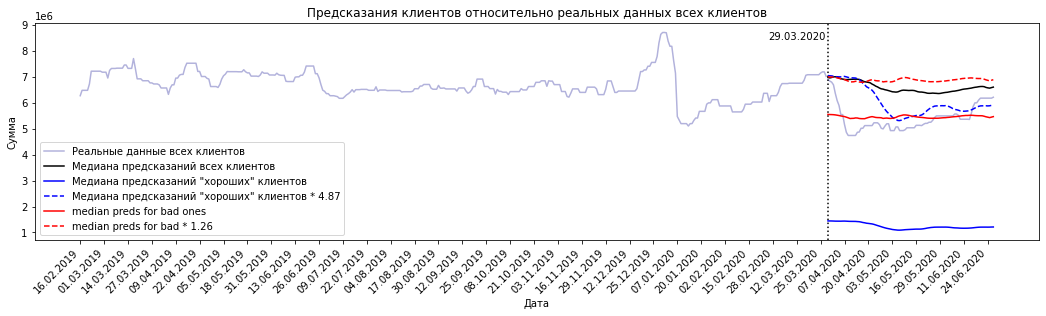

In [174]:
plt.plot(yt_all, c='darkblue', alpha=.3, label='Реальные данные всех клиентов')

plt.axvline(len(yt_all), ls=':', c='k')
plt.text((len(yt_all))*0.92, plt.gca().get_ylim()[1]*0.95, 
         f'{days.iloc[-split]}', rotation=0)
plt.xticks(xt, ticks.iloc[xt], rotation=45, ha='right')

plt.plot(np.arange(len(yt), len(yt)+split-2), median_preds_all, label='Медиана предсказаний всех клиентов', c='black')
plt.plot(np.arange(len(yt), len(yt)+split-2), all_rw[-split:-2].values.reshape(-1),c='darkblue', alpha=.3)

plt.plot(np.arange(len(yt), len(yt)+split-2), median_preds, label='Медиана предсказаний "хороших" клиентов', c='blue')
plt.plot(np.arange(len(yt), len(yt)+split-2), coeff * np.array(median_preds) , '--', label=f'Медиана предсказаний "хороших" клиентов * {coeff:.2f}', c='blue')

plt.plot(np.arange(len(yt), len(yt)+91), median_preds_bad, label='median preds for bad ones', c='red')
plt.plot(np.arange(len(yt), len(yt)+91), coeff_bad * np.array(median_preds_bad) , '--', label=f'median preds for bad * {coeff_bad:.2f}', c='red')

plt.title('Предсказания клиентов относительно реальных данных всех клиентов')
plt.ylabel('Сумма')
plt.xlabel('Дата')
plt.legend();

In [177]:
# MAPE для каждого из 77 предсказаний
temp_vs_all = pd.DataFrame({'good':mape_good_pred_vs_all,'all': fwd_mapes_all, 'bad':mape_bad_pred_vs_all})
temp_vs_all

,good,all,bad
0,0.254412,0.246026,0.243317
1,0.283367,0.275054,0.272670
2,0.309913,0.301810,0.298974
3,0.335559,0.327402,0.324431
4,0.357620,0.348522,0.344844
...,...,...,...
72,0.046350,0.140172,0.203068
73,0.046126,0.129887,0.190820
74,0.045879,0.119458,0.178632
75,0.045389,0.108901,0.166336


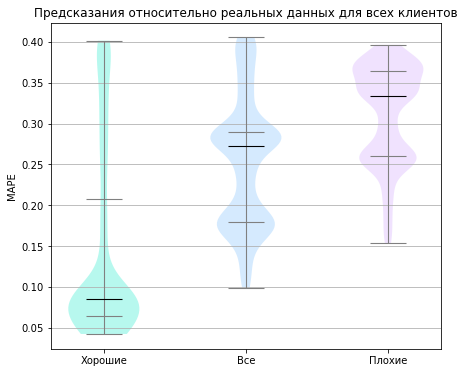

In [178]:
# График

plt.rcParams['figure.figsize'] = 7, 6

viols = plt.violinplot(dataset=temp_vs_all,showmedians=True,bw_method=0.2,
                       quantiles=[[0.25,0.75],[0.25,0.75],[0.25,0.75]])
plt.xticks([1,2,3],['Хорошие','Все','Плохие'])

viols['bodies'][0].set_facecolor('xkcd:aqua')
viols['bodies'][1].set_facecolor('xkcd:sky blue')
viols['bodies'][2].set_facecolor('xkcd:lilac')

for partname in ('cbars','cmins','cmaxes','cquantiles'):
    vp = viols[partname]
    vp.set_linewidth(1.1)
    vp.set_edgecolor('gray')
    
viols['cmedians'].set_edgecolor('black')
viols['cmedians'].set_linewidth(1.1)

plt.grid(axis='y')
plt.ylabel('MAPE')
plt.title('Предсказания относительно реальных данных для всех клиентов');

In [181]:
mape_hp = 0.1

print(f'ALL vs ALL preds: test MAPE median: {np.median(np.array(fwd_mapes_all)) * 100 :.3f}%')
print(f'ALL vs ALL preds: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(fwd_mapes_all)<=mape_hp)[0].shape[0] / np.array(fwd_mapes_all).shape[0]) * 100 :.3f}%\n')

print(f'GOOD vs ALL preds: test MAPE median: {np.median(np.array(mape_good_pred_vs_all)) * 100 :.3f}%')
print(f'GOOD vs ALL preds: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(mape_good_pred_vs_all)<=mape_hp)[0].shape[0] / np.array(mape_good_pred_vs_all).shape[0]) * 100 :.3f}%\n')

print(f'BAD vs ALL preds: test MAPE median: {np.median(np.array(mape_bad_pred_vs_all)) * 100 :.3f}%')
print(f'BAD vs ALL preds: test MAPE HP (<={mape_hp*100}%): {(np.where(np.array(mape_bad_pred_vs_all)<=mape_hp)[0].shape[0] / np.array(mape_good_pred_vs_all).shape[0]) * 100 :.3f}%')

ALL vs ALL preds: test MAPE median: 27.302%
ALL vs ALL preds: test MAPE HP (<=10.0%): 1.299%

GOOD vs ALL preds: test MAPE median: 8.521%
GOOD vs ALL preds: test MAPE HP (<=10.0%): 63.636%

BAD vs ALL preds: test MAPE median: 33.318%
BAD vs ALL preds: test MAPE HP (<=10.0%): 0.000%
